In [7]:
from ultralytics import YOLO
import mediapipe as mp
import cv2
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [6]:
class InterestPredictor(nn.Module):
    def __init__(self, input_size=3, hidden_size=10):
        super(InterestPredictor, self).__init__()

        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)

        return x



interest_predictor = InterestPredictor(input_size=2, hidden_size=10)
interest_predictor.load_state_dict(torch.load('C:/Users/Stepan/Documents/ClassMood/headpose/interest_predictor_model.pth'))
interest_predictor.eval()

InterestPredictor(
  (fc1): Linear(in_features=2, out_features=10, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=10, out_features=1, bias=True)
)

In [16]:
class HeadPose:
    def __init__(self):
        self.bb_detection = YOLO('C:/Users/Stepan/Documents/ClassMood/headpose/yolov8n-face-lindevs.pt')
        self.face_mesh = mp.solutions.face_mesh.FaceMesh(
            static_image_mode=True,
            max_num_faces=1,
            refine_landmarks=True,
            min_detection_confidence=0.5,
            min_tracking_confidence=0.5
        )

    def frame_headpose(self, path):
        bb_results = self.bb_detection(path, conf=0.4, verbose=False)
        try:
            image = cv2.imread(path)
        except:
            image = path

        if not bb_results:
            return None
        
        h, w = image.shape[:2]
        boxes = bb_results[0].boxes.xyxy.numpy()
        head_rotations = dict()
        point_names = ('nose', 'chin', 'le_in', 're_in')

        for face_id, coords in enumerate(boxes):
            face_roi = image[int(coords[1]):int(coords[3]), int(coords[0]):int(coords[2])]
            mesh_results = self.face_mesh.process(cv2.cvtColor(face_roi, cv2.COLOR_BGR2RGB))

            if not mesh_results.multi_face_landmarks:
                break
            
            roi_h, roi_w = face_roi.shape[:2]
            landmarks_3d = dict(zip(point_names, [(mesh_results.multi_face_landmarks[0].landmark[i].x, mesh_results.multi_face_landmarks[0].landmark[i].y, mesh_results.multi_face_landmarks[0].landmark[i].z) for i in (1, 152, 130, 359)]))

            yaw_approx = ((((landmarks_3d['le_in'][0] - landmarks_3d['nose'][0]) ** 2 + (landmarks_3d['le_in'][1] - landmarks_3d['nose'][1]) ** 2) ** 0.5) - (((landmarks_3d['re_in'][0] - landmarks_3d['nose'][0]) ** 2 + (landmarks_3d['re_in'][1] - landmarks_3d['nose'][1]) ** 2) ** 0.5)) / roi_w * 100000 
            pitch_approx = (landmarks_3d['nose'][2] + landmarks_3d['chin'][2]) * -100

            head_rotations[face_id] = (yaw_approx / (w / max((coords[0] + coords[2]), 0.1 ** 6)), pitch_approx)
        
        return head_rotations
    
    def video_interest(self, path, frame_skip=5, visualise=False):
        cap = cv2.VideoCapture(path)
        frame_count = 0
        fps = cap.get(cv2.CAP_PROP_FPS)
        main_df = dict()

        while cap.isOpened():
            ret, frame = cap.read()

            if not ret:
                break
            
            if frame_count % frame_skip == 0:
                temp = self.frame_headpose(frame)
                predicted = []
                with torch.no_grad():
                    for i in temp.keys():
                        predicted.append(float(interest_predictor(torch.tensor([temp[i][0], temp[i][1]], dtype=torch.float32))))
                main_df[round(frame_count / fps, 3)] = min(max(sum(predicted) / len(predicted), 0), 100)

            frame_count += 1

        if visualise == True:
            x_values = main_df.keys()
            y_values = main_df.values()

            plt.figure(figsize=(10, 6))
            plt.plot(x_values, y_values, label='Заинтер. человек', marker='o') 

            plt.xlabel('Время, сек')
            plt.ylabel('Заинтересованность, %')

            plt.legend()
            plt.grid(True)
            plt.show()

        return main_df

In [17]:
headpose = HeadPose()

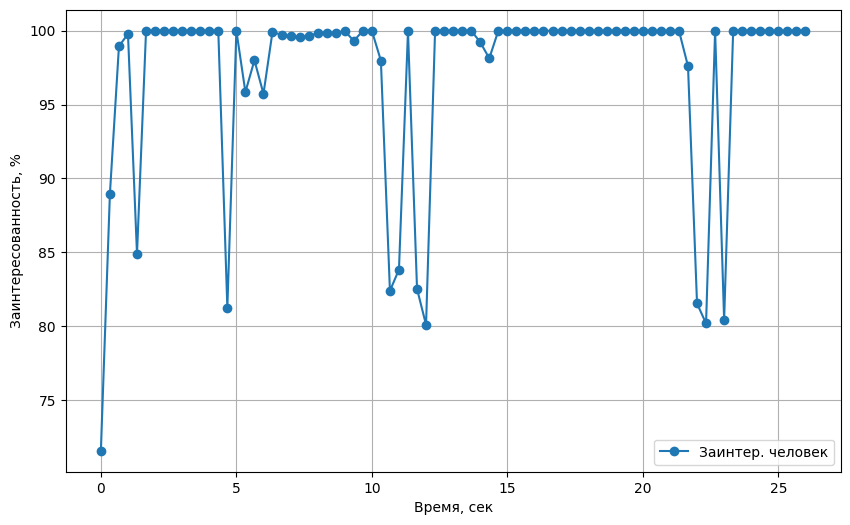

{0.0: 71.56370544433594,
 0.333: 88.95509338378906,
 0.667: 98.95048522949219,
 1.0: 99.78388977050781,
 1.333: 84.88749694824219,
 1.667: 100,
 2.0: 100,
 2.333: 100,
 2.667: 100,
 3.0: 100,
 3.333: 99.99748229980469,
 3.667: 99.99185180664062,
 4.0: 100,
 4.333: 100,
 4.667: 81.24937438964844,
 5.0: 100,
 5.333: 95.84587097167969,
 5.667: 98.00218200683594,
 6.0: 95.72611999511719,
 6.333: 99.92674255371094,
 6.667: 99.71145629882812,
 7.0: 99.65061950683594,
 7.333: 99.58099365234375,
 7.667: 99.64410400390625,
 8.0: 99.83097839355469,
 8.333: 99.85438537597656,
 8.667: 99.84449768066406,
 9.0: 99.99501037597656,
 9.333: 99.30386352539062,
 9.667: 100,
 10.0: 100,
 10.333: 97.97943115234375,
 10.667: 82.38771057128906,
 11.0: 83.82809448242188,
 11.333: 99.96391296386719,
 11.667: 82.52439880371094,
 12.0: 80.0849609375,
 12.333: 100,
 12.667: 100,
 13.0: 100,
 13.333: 100,
 13.667: 100,
 14.0: 99.22285461425781,
 14.333: 98.12776184082031,
 14.667: 100,
 15.0: 100,
 15.333: 100,
 1

In [18]:
headpose.video_interest('C:/Users/Stepan/Documents/ClassMood/headpose/videos/6.MOV', frame_skip=10, visualise=True)